<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget - nc https://lazyprogrammer.me/course_files/SPY.csv

In [2]:
!pip install -U arch statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [4]:
df = pd.read_csv("SPY.csv",index_col = 'Date',parse_dates = True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [6]:
df['LogRet'] = np.log(df['Close']).diff()

In [7]:
#Because the first row do not contain any return value
df2 = df.iloc[1:].copy()

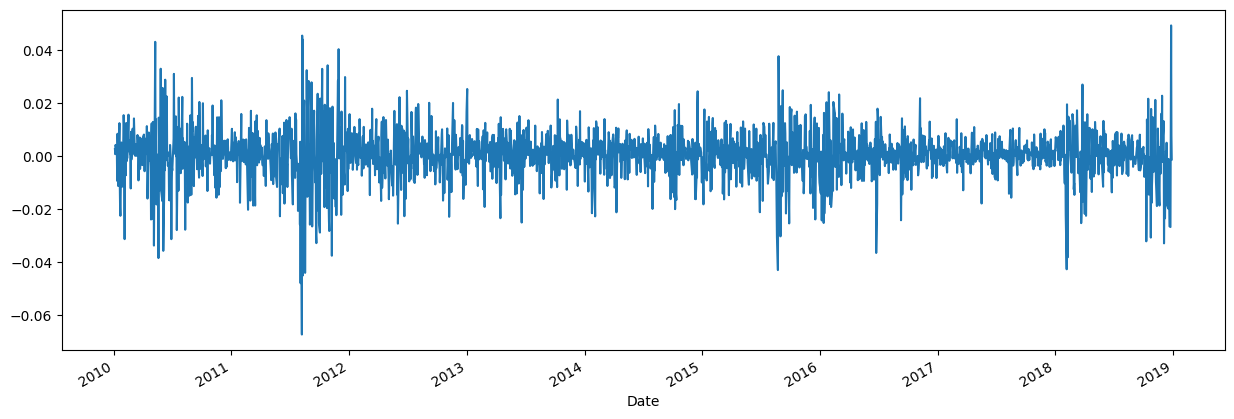

In [8]:
df2['LogRet'].plot(figsize = (15,5));

In [9]:
df2['Ysq'] = df2['LogRet'] ** 2

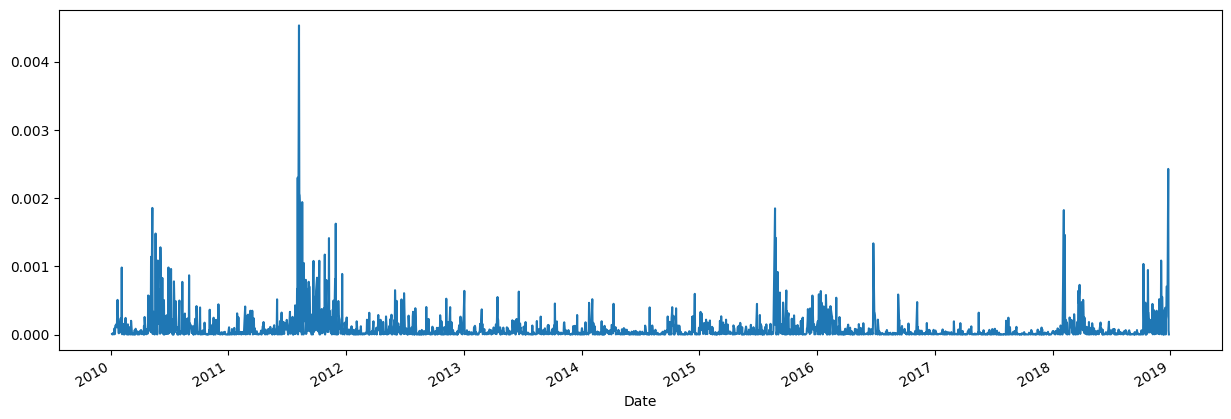

In [10]:
df2['Ysq'].plot(figsize = (15,5));

# **ACF and PACF**

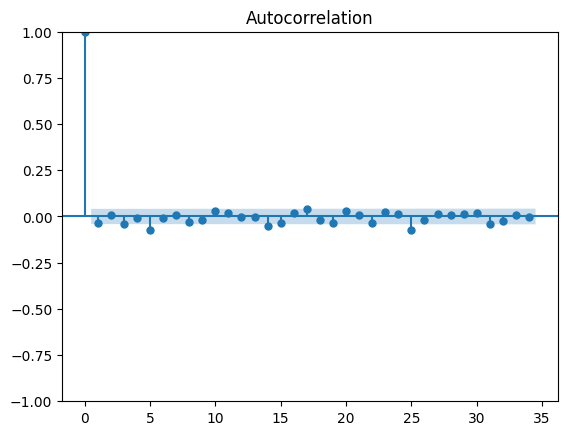

In [11]:
plot_acf(df2['LogRet']);

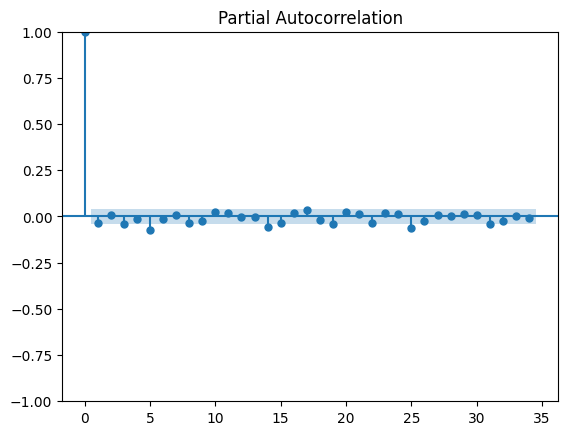

In [12]:
plot_pacf(df2['LogRet']);

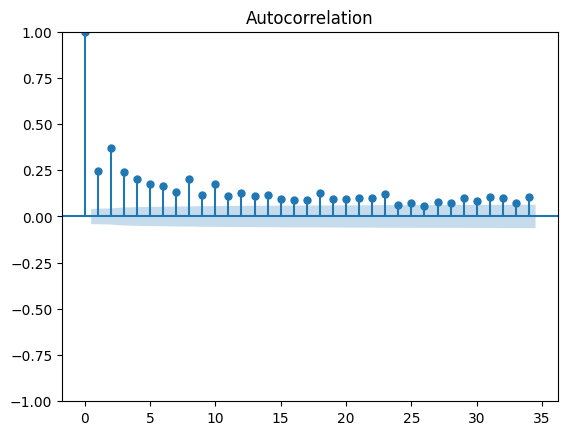

In [13]:
plot_acf(df2['Ysq']);

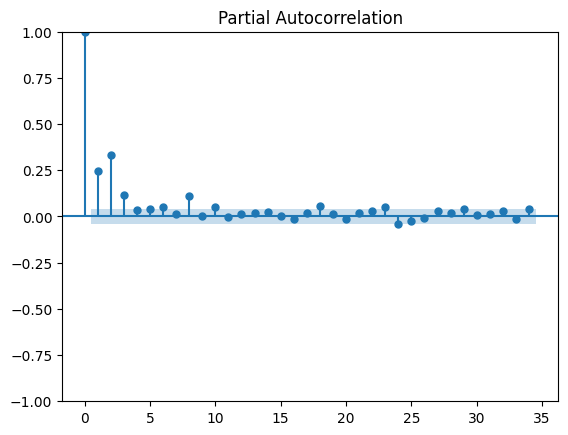

In [15]:
plot_pacf(df2['Ysq']);

# **Train-Test Split**

In [16]:
NTest = 500
train = df2.iloc[:-NTest][['LogRet']].copy()
test = df2.iloc[-NTest:][['LogRet']].copy()

# **GARCH**

In [17]:
model = arch_model(train['LogRet'],vol = 'GARCH',p = 1,q = 1)

In [18]:
#It gives warnning because the scales are to small
#The parameter estimation works better when this value is between 1 and 1000
#Thus, we need to scale our time series
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2668736234320.3926
Iteration:      2,   Func. Count:     19,   Neg. LLF: 681495796603480.9
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2099329788588.272
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1148800069593708.8
Iteration:      5,   Func. Count:     62,   Neg. LLF: 20672973870.71515
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.0138966357037168e+16
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1121326932594.181
Iteration:      8,   Func. Count:    103,   Neg. LLF: 207123748884025.1
Iteration:      9,   Func. Count:    118,   Neg. LLF: 14017524989.133617
Iteration:     10,   Func. Count:    131,   Neg. LLF: 275892953358924.4
Iteration:     11,   Func. Count:    145,   Neg. LLF: -5876.685308750586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5876.68531086581
            Iterations: 15
            Function evaluations: 145
            Gradient evalu

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.532e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
#Scaling
m = train['LogRet'].mean()
s = test['LogRet'].std()
train['scaled'] = (train['LogRet'] - m)/s
test['scaled'] = (test['LogRet'] - m)/s
df2['scaled'] = (df2['LogRet'] - m)/s

In [20]:
arch1 = arch_model(train['scaled'],vol = 'ARCH',p=1)

In [21]:
res_arch1 = arch1.fit(update_freq = 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2758.9937048800584
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


In [22]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2758.99
Distribution:                  Normal   AIC:                           5523.99
Method:            Maximum Likelihood   BIC:                           5540.41
                                        No. Observations:                 1762
Date:                Fri, Nov 24 2023   Df Residuals:                     1761
Time:                        05:42:58   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0150  2.759e-02      0.545      0.586 [-3.904e-02,6.910e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1523  9.460e-02     12.181  3.936e-34   [  0.967,  1.338]
alpha[1]       0.1771  4.774e-02      3.709  2.079e-04 [8.350e-02,  0.271]
==========================================================================

Covariance estimator: robust
"""

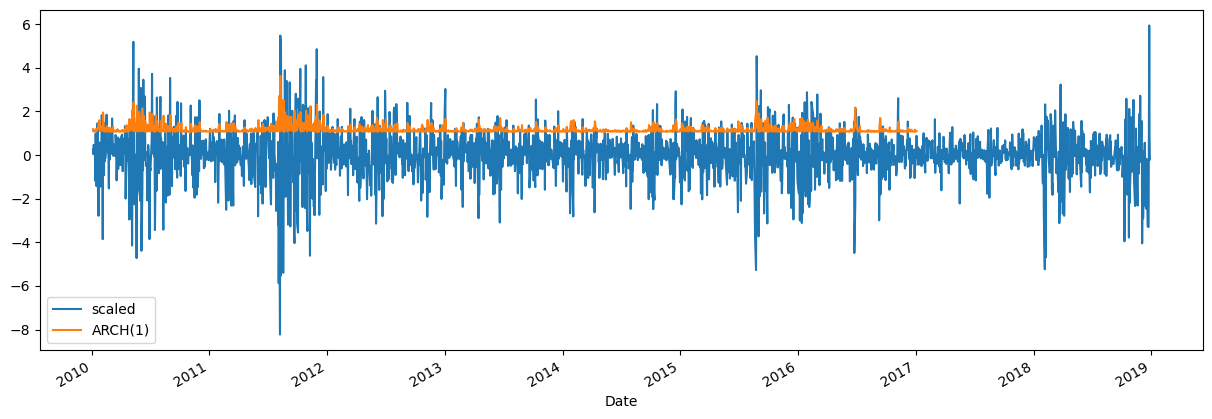

In [25]:
df2['ARCH(1)'] = res_arch1.conditional_volatility
df2[['scaled','ARCH(1)']].plot(figsize = (15,5));

In [26]:
res_arch1.forecast(horizon = NTest)